In [3]:
import pandas as pd 
import networkx as nx 
from cdlib import algorithms
import numpy as np
from matplotlib import pyplot as plt
import sknetwork as skn
from sknetwork.embedding import Spectral
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import torch 
from sklearn.decomposition import PCA, KernelPCA
#import torch_geometric
import os

# Graph Convolutional Network (GCN) `Node Classification` Tutorial. 

We will be using a GCN to perform node classification on the `cora` dataset. 

# Cora Dataset Readme|

This directory contains the a selection of the Cora dataset (www.research.whizbang.com/data).

The Cora dataset consists of Machine Learning papers. These papers are classified into one of the following seven classes:
                Case_Based
                Genetic_Algorithms
                Neural_Networks
                Probabilistic_Methods
                Reinforcement_Learning
                Rule_Learning
                Theory

The papers were selected in a way such that in the final corpus every paper cites or is cited by atleast one other paper. There are 2708 papers in the whole corpus.

After stemming and removing stopwords we were left with a vocabulary of size 1433 unique words. All words with document frequency less than 10 were removed.


THE DIRECTORY CONTAINS TWO FILES:

The .content file contains descriptions of the papers in the following format:

                <paper_id> <word_attributes>+ <class_label>

The first entry in each line contains the unique string ID of the paper followed by binary values indicating whether each word in the vocabulary is present (indicated by 1) or absent (indicated by 0) in the paper. Finally, the last entry in the line contains the class label of the paper.

The .cites file contains the citation graph of the corpus. Each line describes a link in the following format:

                <ID of cited paper> <ID of citing paper>

Each line contains two paper IDs. The first entry is the ID of the paper being cited and the second ID stands for the paper which contains the citation. The direction of the link is from right to left. If a line is represented by "paper1 paper2" then the link is "paper2->paper1".

# Load the data

In [6]:
data_dir = os.path.expanduser("./data/cora")
print(data_dir)

./data/cora


In [7]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"
edgelist.head()

,target,source,label
0,35,1033,cites
1,35,103482,cites
2,35,103515,cites
3,35,1050679,cites
4,35,1103960,cites


In [8]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)
node_data.head()

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


# Create Networkx graph 

This is for convenient conversion between edgelist and adjacency matrix - and for EDA.

In [11]:
G = nx.from_pandas_edgelist(edgelist)
len(G)

2708

# Data Prep.

In [12]:
def get_data(): 
    '''prepare data'''
    A = torch.tensor(nx.adj_matrix(G, nodelist=list(node_data.index)).todense(), dtype=torch.float)
    str_y = node_data.subject.values

    # onehot encode paper label
    labels_enc = np.unique(str_y)
    y_idx = np.array([np.where(labels_enc == ystr)[0][0] for ystr in str_y])
    #y = np.eye(labels_enc.shape[0])[y_idx]
    y = y_idx # cross entropy loss takes one hot encoding index 
    x = torch.tensor(node_data[node_data.columns[:-1]].values, dtype=torch.float)

    A = torch.tensor(A, dtype=torch.float) 
    y = torch.tensor(y, dtype=torch.long)
    x = torch.tensor(x, dtype=torch.float)

    _idx = np.arange(y.size(0))
    train_idx = np.random.choice(_idx, size=int(0.7*(y.size(0))), replace=False)
    _idx = _idx[~np.isin(_idx, train_idx)]
    test_idx = np.random.choice(_idx, size=int(0.15*(y.size(0))), replace=False)
    val_idx = _idx[~np.isin(_idx, test_idx)]

    train_idx = torch.tensor(train_idx, dtype=torch.long)
    test_idx = torch.tensor(test_idx, dtype=torch.long)
    val_idx = torch.tensor(val_idx, dtype=torch.long)

    return A,x,y,train_idx,test_idx,val_idx, labels_enc

A,x,y,train_idx,test_idx,val_idx, labels_enc = get_data()

In [16]:
print('train length:', len(train_idx))
print('test length:', len(test_idx))
print('val length:', len(val_idx))
print('total:', len(train_idx) + len(test_idx) + len(val_idx))

train length: 1895
test length: 406
val length: 407
total: 2708


In [17]:
# double check our train,test,val don't overlap 
print(np.isin(train_idx,test_idx).any())
print(np.isin(train_idx,val_idx).any())

False
False


In [18]:
print('CLASS COUNTS')
print('------------')
label_idx, label_counts = np.unique(y, return_counts=True)
for k,v in zip(label_idx, label_counts): 
    print(labels_enc[k], ':', v)

CLASS COUNTS
------------
Case_Based : 298
Genetic_Algorithms : 418
Neural_Networks : 818
Probabilistic_Methods : 426
Reinforcement_Learning : 217
Rule_Learning : 180
Theory : 351


# Define our Graph Convolutional Network (GCN) 

We're using `pytorch` for this, which handles differentiation and optimization.

In [13]:
class GNN(torch.nn.Module): 
    def __init__(self, input, channels, output, cache=True, add_self_loops=True): 
        super(GNN, self).__init__() 
        self.f1 = torch.nn.Linear(input, channels)
        self.f2 = torch.nn.Linear(channels, channels)
        self.f_out = torch.nn.Linear(channels, output)
        self.nonlin = torch.nn.ReLU()
        self.cache = cache
        self.norm = None
        self.add_self_loops = add_self_loops

    def norm_adj(self, A): 
        '''symetric normalization'''
        if self.add_self_loops: A[np.eye(A.size(0), dtype=bool)] = 1
        Dinv = torch.diag_embed(torch.pow(A.sum(dim=-1),-0.5))
        return Dinv @ A @ Dinv

    def _norm(self, A): 
        if self.cache and (self.norm is None): 
            A = self.norm_adj(A)
            self.norm = A 
        elif self.cache: 
            A = self.norm 
        else: 
            A = self.norm_adj(A)
        return A

    def get_embedding(self, A, x): 
        A = self._norm(A)
        h1 = self.nonlin( A @ self.f1(x) )
        h2 = self.nonlin( A @ self.f2(h1) )
        return h2

    def forward(self, A, x):  
        out = self.get_embedding(A,x)
        return torch.softmax( self.f_out(out), dim=-1 )

# Initialize our GCN model 

In [15]:
hidden_channels = 64        # embedding dimension
n_epochs = 2000             # how many iterations to train
lr = 1e-4                   # step size for gradient descent 

A,x,y,train_idx,test_idx,val_idx, labels_enc = get_data()
model = GNN(x.size(1), 64, len(labels_enc), cache=True, add_self_loops=True)
optim = torch.optim.Adam(model.parameters(), lr=lr)
crit = torch.nn.CrossEntropyLoss()

# Train the GCN model

In [16]:
model = model.train()

test_acc = [] 
train_acc = []
val_acc = []

for epoch in range(n_epochs):
    yhat = model(A, x)
    loss = crit(yhat[train_idx, :], y[train_idx])
    loss.backward() 
    optim.step()

    train_acc.append((1.*(torch.argmax(yhat[train_idx, :], dim=-1) == y[train_idx])).mean().item())
    test_acc.append((1.*(torch.argmax(yhat[test_idx, :], dim=-1) == y[test_idx])).mean().item())
    val_acc.append((1.*(torch.argmax(yhat[val_idx, :], dim=-1) == y[val_idx])).mean().item())

    print(f'EPOCH: {epoch} || train acc: {train_acc[-1]:.2f}  || test acc: {test_acc[-1]:.2f}', end='\r')
    

# GCN Evaluation

In [17]:
best_test_idx = np.where(np.array(test_acc) == max(test_acc))[0][0]
val_acc_at_best_test = np.array(val_acc)[best_test_idx]
print('best test epoch:', best_test_idx)
print('GNN test set accuracy:', np.array(test_acc)[best_test_idx])
print('GNN validation set accuracy:', val_acc_at_best_test)

best test epoch: 1689
GNN test set accuracy: 0.8004925847053528
GNN validation set accuracy: 0.8353808522224426


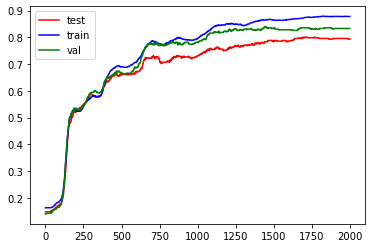

In [18]:
plt.figure()
plt.plot(test_acc, 'r-', label='test')
plt.plot(train_acc, 'b-', label='train')
plt.plot(val_acc, 'g-', label='val')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

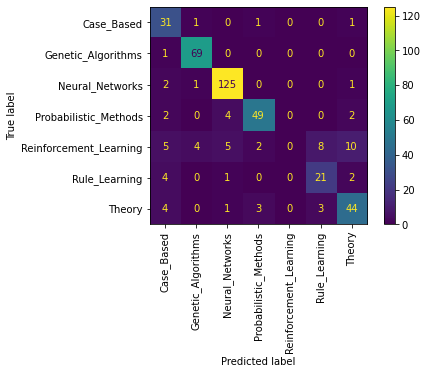

In [19]:
model = model.eval()
yhat = model(A, x)
plt.figure()
cm = confusion_matrix(y[val_idx].detach().numpy(), torch.argmax(yhat[val_idx, :], dim=-1).detach().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_enc)
disp.plot(xticks_rotation='vertical')

# Visualize the `node embedding`

In [20]:
embed = model.get_embedding(A,x).detach().numpy()
pca = PCA(n_components=2)
pc = pca.fit_transform(embed)

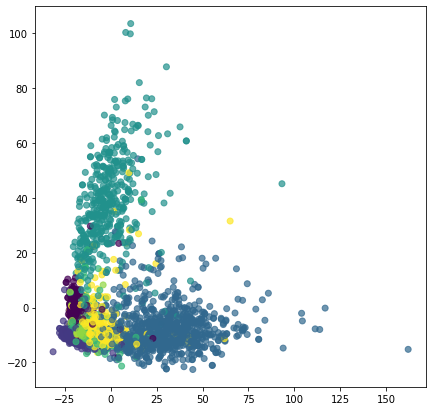

In [21]:
plt.figure(figsize=(7,7))
plt.scatter(pc[:,0], pc[:,1], c=y[:], alpha=0.7)
plt.show()

# Wait a minute, can we predict the class labels using JUST the node features? 

Maybe we don't need edges at all - do they add predictive power? 

In [22]:
class NN(torch.nn.Module): 
    def __init__(self, input, channels, output): 
        super(NN, self).__init__() 
        self.f = torch.nn.Sequential(torch.nn.Linear(input, channels), 
                                     torch.nn.ReLU(), 
                                     torch.nn.Linear(channels, channels), 
                                     torch.nn.ReLU(), 
                                     torch.nn.Linear(channels, output))

    def forward(self, x):  
        return torch.softmax( self.f(x), dim=-1 )

In [23]:
model2 = NN(x.size(1), hidden_channels, len(labels_enc))
optim = torch.optim.Adam(model2.parameters(), lr=lr)
crit = torch.nn.CrossEntropyLoss()

In [24]:
model2 = model2.train()

test_acc = [] 
train_acc = []
val_acc = []

for epoch in range(n_epochs):
    yhat = model2(x)
    loss = crit(yhat[train_idx, :], y[train_idx])
    loss.backward() 
    optim.step()

    train_acc.append((1.*(torch.argmax(yhat[train_idx, :], dim=-1) == y[train_idx])).mean().item())
    test_acc.append((1.*(torch.argmax(yhat[test_idx, :], dim=-1) == y[test_idx])).mean().item())
    val_acc.append((1.*(torch.argmax(yhat[val_idx, :], dim=-1) == y[val_idx])).mean().item())

    print(f'EPOCH: {epoch} || train acc: {train_acc[-1]:.2f}  || test acc: {test_acc[-1]:.2f}', end='\r')

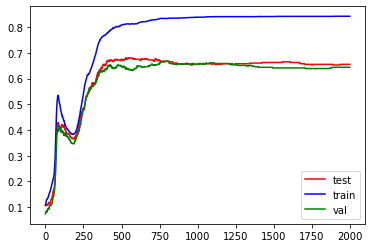

In [25]:
plt.figure()
plt.plot(test_acc, 'r-', label='test')
plt.plot(train_acc, 'b-', label='train')
plt.plot(val_acc, 'g-', label='val')
plt.legend()
plt.show()

In [26]:
best_test_idx = np.where(np.array(test_acc) == max(test_acc))[0][0]
val_acc_at_best_test = np.array(val_acc)[best_test_idx]
print('best test epoch:', best_test_idx)
print('GNN test set accuracy:', np.array(test_acc)[best_test_idx])
print('GNN validation set accuracy:', val_acc_at_best_test)

best test epoch: 526
GNN test set accuracy: 0.6798029541969299
GNN validation set accuracy: 0.6388206481933594
